In [2]:
from __future__ import division
from numpy import *
%pylab inline
import matplotlib.cm as mcm
style.use('bmh')

Populating the interactive namespace from numpy and matplotlib


In [25]:
t_pet = 12.5e-6 #12.5 micron pet layer
t_cf = 150e-6 #100 micron cf layer
nu = .4
w = 5e-3 #width of electrode patch (m)
l = 20e-3 #length of electrode patch (m)
epsilon_0 = 8.85418782e-12 #permittivity of free space
epsilon_r = 3.0 #pet relative permittivity
tip_d = 1e-3 #tip displacement (m)

R = l**2/(2*tip_d) #taylor approximation of radius of curvature from tip displacement
e_l = (t_cf+t_pet)/(2*R) #strain of pet in length direction, assuming cf layer is inextensible along its medial axis
#e_t = -nu*e_l #assume free to contract in width direction, later we'll correct for this constraint.
e_t = -nu/(1-nu)*e_l #assuming e_w=0, see derivation below.
t_pet_strained = t_pet + e_t*t_pet

print "Radius of curvature: %.2f mm"%(R*1e3)
print "Unstrained film thickness: %.3f um"%(t_pet*1e6)
print "Unstrained film thickness: %.3f um"%(t_pet_strained*1e6)
A = l*w
C_0 = epsilon_0*epsilon_r*A/t_pet
C_strained = epsilon_0*epsilon_r*A/t_pet_strained

print "Unstrained capacitance: %.4f pF"%(C_0*1e9)
print "Strained capacitance: %.4f pF"%(C_strained*1e9)

Radius of curvature: 200.00 mm
Unstrained film thickness: 12.500 um
Unstrained film thickness: 12.497 um
Unstrained capacitance: 0.2125 pF
Strained capacitance: 0.2126 pF


Assume the elementry isotropic form of Hooke's law:
$$
E e_{xx}= s_{xx}- \nu s_{yy}-\nu s_{zz}
$$
$$
E e_{yy}= s_{yy}- \nu s_{zz}-\nu s_{xx}
$$
$$
E e_{zz}= s_{zz}- \nu s_{xx}-\nu s_{yy}
$$
If we have a film laminated to a bending substrate, we can calculate 
$$
e_{xx} = \frac{t_{substrate}+t}{2 R}
$$
where $R$ is the assumed radius of curvature for the bend and $t$ is the film thickness.  We assume perfect lamination, so $e_{yy}=0$ and no forces normal to the surface so $s_{zz}=0$. Then
$$
s_{yy} = \nu s_{xx}
$$
and 
$$
s_{xx} = \frac{E e_{xx}}{1-\nu^2}
$$
Thus, we can solve to determine the strain in the thickness direction:
$$
e_{zz} = -\frac{\nu e_{xx}}{1-\nu} = -\frac{\nu (t_{substrate}+t)}{2R(1-\nu)}
$$
This means
$$
\Delta t = -t\frac{\nu (t_{substrate}+t)}{2R(1-\nu)}
$$
and so the new film thickness is
$$
t_R = t + \Delta t = t\left(1-\frac{\nu (t_{substrate}+t)}{2R(1-\nu)}\right)
$$
The unstrained capacitance between electrodes on top and bottom of the film is 
$$
C_\infty = \frac{\epsilon l w}{t}
$$
And so the strained capacitance is
$$
C_R = \frac{\epsilon l w}{t_R} = \frac{C_\infty}{1-\frac{\nu (t_{substrate}+t)}{2R(1-\nu)}}
$$
That is, the relevant quantity to determine the factor by which capacitance changes is 
$$
1-\frac{\nu}{(1-\nu)}\frac{ (t_{substrate}+t)}{2R}
$$
We would like this quantity to approach zero.  That is, 
$$
\frac{\nu}{(1-\nu)} \approx \frac{2R}{ (t_{substrate}+t)}
$$
The left side of this equation is easily calculated -- we plot below.  For realistic values of Poisson ratio, this quantity is around 0.5. Thus, we want  
$$
t_{substrate}+t \approx 4R
$$
I think this shows capacitance change by stretching via bending is a bad idea!  

So how to the Wood Lab's DEA unimorphs work?  Multilayer means an effectively larger $t_{substrate}$.  Capacitance change value is multiplied by number of layers, even though change factor is the same as single layer.  Does this relation imply the configuration is good for actuators looking to maximize stroke, but bad for generators looking to operate using a smallish stroke.

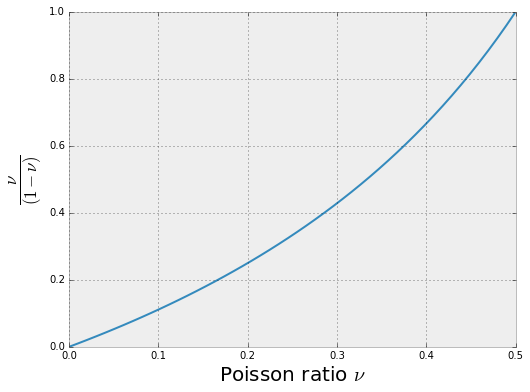

In [42]:
figure(figsize=(8,6),dpi=300)
nus = linspace(0,.5)
plot(nus,nus/(1-nus))
xlabel(r'Poisson ratio $\nu$', fontsize=20)
ylabel(r'$\frac{\nu}{(1-\nu)}$', fontsize=24)

For the right side, we must calculate $R$, assume a circular arc deformation shape (constant curvature) with tip displacement $d$.  Then 
$$
R - d = R \cos{l/R}
$$
where $l$ is the length of the bending element.  Now for $R>>l$, $\cos{l/R} \approx 1 - l^2/2R^2$ and so
$$
R = \frac{l^2}{2d}
$$

### Refs

http://silver.neep.wisc.edu/~lakes/PoissonIntro.html

# Electrostatic generation

Now let's look at pure electrostatic generation, no elastomers.

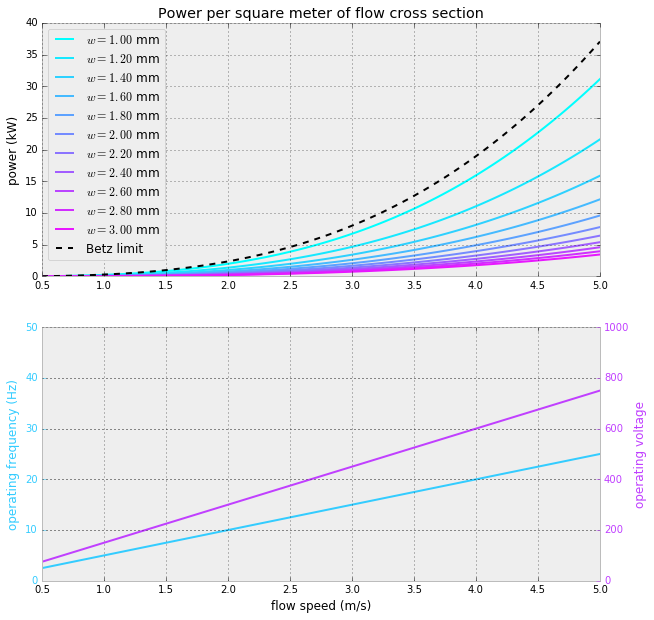

In [39]:
def frequency(U,l):
    #lower bound
    return U/(2*l)
def tip_speed_ratio(U,l,w):
    return 2*w*frequency(U,l)/U
def delta_energy(V,epsilon,s,l,w):
    return V*V*epsilon*s*l/w
def flow_power(U,rho,A):
    return .5*rho*A*U**3
def betz_power(U,rho,A):
    return 16/27*flow_power(U,rho,A)

cm = mcm.cool

#U = 10 #m/s
#V = 1000 #volts
epsilon_0 = 8.85418782e-12
epsilon_r = 3
l = 100e-3 #length of cell (meters), this drops out
s = 12e-3 #hex side length
w = 2e-3 #cell width (travel between states)
rho_water = 1e3 #kg/m^3
rho_air = 1 #kg/m^3

X = 1 #side length wrt w
Y = 1 #side length wrt s

N = 11
Us = linspace(.5,5,100)
Vs = 150*Us
fig,axarr = subplots(2,1,figsize=(10,10))
for i,w in enumerate(linspace(1e-3,3e-3,N)):
    n_cells = (X/w)*(Y/(1.2*s))
    cell_power = frequency(Us,l)*delta_energy(Vs,epsilon_0*epsilon_r,s,l,w)
    axarr[0].plot(Us, n_cells*cell_power,label='$w=%.2f$ mm'%(w*1e3),c=cm(float(i)/N))
axarr[1].plot(Us, frequency(Us,l),c=cm(.2))
axarr[1].tick_params('y', colors=cm(.2))

ax2 = axarr[1].twinx()
ax2.plot(Us, Vs, c=cm(.75))
ax2.tick_params('y', colors=cm(.75))

#ax2.set_ylabel('sin', color='r')
#ax2.tick_params('y', colors='r')


#axarr[1].plot(Us, tip_speed_ratio(Us,l,w))
#axarr[0].plot(Us, betz_power(Us,rho_water, s*w), c='black',ls='--',label='Betz limit')
axarr[0].plot(Us, 1e-3*betz_power(Us,rho_water, X*Y), c='black',ls='--',label='Betz limit')

axarr[0].set_ylabel('power (kW)')
axarr[1].set_ylabel('operating frequency (Hz)', color=cm(.2))
ax2.set_ylabel('operating voltage', color=cm(.75))
axarr[1].set_ylim([0,50])
ax2.set_ylim([0,1000])
axarr[1].set_xlabel('flow speed (m/s)')
axarr[0].legend(loc='upper left')
axarr[0].set_title('Power per square meter of flow cross section')

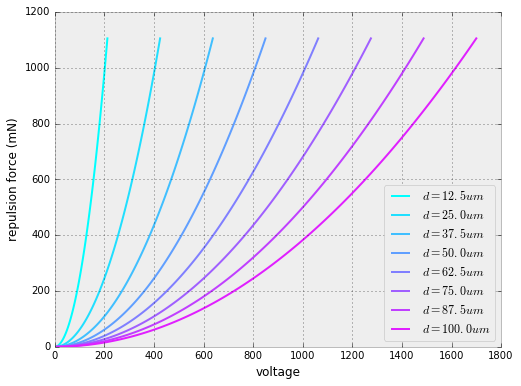

In [41]:
#electrostatic repulsion of two charged plates
def coulomb_force(V,epsilon,A,d):
    return epsilon*A*V*V/(2*d*d)
s = 12e-3 #hex side length
l = 24e-3
#d = 1e-4
dialectric_strength = 17 #V/um
figure(figsize=(8,6))
N = 8
for i,d in enumerate(linspace(12.5e-6,1e-4,N)):
    #safe_vs = where(Vs < dialectric_strength*1e6*d)[0]
    Vs = linspace(10,dialectric_strength*1e6*d,100)
    #print safe_vs
    plot( Vs, 1e3*coulomb_force(Vs, epsilon_r*epsilon_0, s*l, d ), label=r'$d=%.1f um$'%(1e6*d), c=cm(float(i)/N) )
xlabel('voltage')
ylabel('repulsion force (mN)')
legend(loc='lower right')

### calculating peel forces

Just from Bernoulli:

$$
F_h = \frac{1}{2}\rho b d U_0^2 \cos{\theta} \left( \frac{h^2}{(h-\frac{d}{2}\sin{\theta})^2} -1\right)
$$

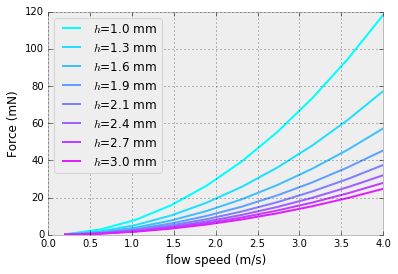

In [17]:
cm = mcm.cool
U_0 = linspace(.2,4,10)
b = 6e-3 #out of plane width of panel, meters
theta = 20*pi/180 #deflection angle, radians
l = 2e-3 #deflection length, meters
rho = 1000 #density, kg/m^3
#h = 2e-3 #cell height, meters
N = 8
for i,h in enumerate(linspace(1e-3,3e-3,N)):
    F_h = .5*rho*b*l*U_0**2*cos(theta)*(h**2/(h-.5*l*sin(theta))**2 -1)
    plot(U_0,1e3*F_h,label='$h$=%.1f mm'%(1e3*h),c=cm(float(i)/N))
ylabel('Force (mN)')
xlabel('flow speed (m/s)')
legend(loc='upper left')